## Import Libraries

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
! pip install tensorflow_addons
! pip install scikit-plot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 9.3 MB/s eta 0:00:00


In [ ]:
import random
import os
import glob
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.utils import plot_model
import tensorflow_addons as tfa

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, precision_recall_fscore_support,
    accuracy_score, f1_score, matthews_corrcoef,
    confusion_matrix, ConfusionMatrixDisplay
)
from scikitplot.metrics import plot_roc

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Load Dataset

In [ ]:
DATASET_PATH = '/content/drive/MyDrive/Research Paper/Health Science/Paper/Acute Lymphoblastic Leukemia/Dataset/Original/'

In [ ]:
# Generate a summary of the dataset
print('DATASET SUMMARY')
print('========================\n')
for dirpath, dirnames, filenames in os.walk(DATASET_PATH):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")
print('\n========================')

DATASET SUMMARY

There are 4 directories and 0 images in /content/drive/MyDrive/Research Paper/Health Science/Paper/Acute Lymphoblastic Leukemia/Dataset/Original/
There are 0 directories and 804 images in /content/drive/MyDrive/Research Paper/Health Science/Paper/Acute Lymphoblastic Leukemia/Dataset/Original/Pro
There are 0 directories and 985 images in /content/drive/MyDrive/Research Paper/Health Science/Paper/Acute Lymphoblastic Leukemia/Dataset/Original/Early
There are 0 directories and 963 images in /content/drive/MyDrive/Research Paper/Health Science/Paper/Acute Lymphoblastic Leukemia/Dataset/Original/Pre
There are 0 directories and 504 images in /content/drive/MyDrive/Research Paper/Health Science/Paper/Acute Lymphoblastic Leukemia/Dataset/Original/Benign



In [ ]:
df = pd.DataFrame()

In [ ]:
image_path = []
for _dir in os.listdir(DATASET_PATH):
  _path = os.path.join(DATASET_PATH, _dir)
  for _img in os.listdir(_path):
    image_path.append(os.path.join(_path, _img))
image_path = sorted(image_path)

In [ ]:
len(image_path)

3256

In [ ]:
def generate_labels(image_paths):
    return [_.split('/')[-2:][0] for _ in image_paths]


def build_df(image_paths, labels):
    # Create dataframe
    df = pd.DataFrame({
        'image_path': image_paths,
        'label': generate_labels(labels)
    })

    # Generate label encodings
    # df['label_encoded'] = df.apply(lambda row: 0 if row.label == 'malignant' else 1, axis=1)

    # Shuffle and return df
    return df.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
label = image_path[0].split('/')[-2:][0]
label

'Benign'

In [ ]:
images = build_df(image_path, generate_labels(image_path))

In [ ]:
images.head()

,image_path,label
0,/content/drive/MyDrive/Research Paper/Health S...,Pre
1,/content/drive/MyDrive/Research Paper/Health S...,Benign
2,/content/drive/MyDrive/Research Paper/Health S...,Pre
3,/content/drive/MyDrive/Research Paper/Health S...,Pre
4,/content/drive/MyDrive/Research Paper/Health S...,Early


### Dataset Label Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(images['label'])
images['label_encoding'] = le.transform(images['label'])

In [ ]:
sorted(images['label'].unique())

['Benign', 'Early', 'Pre', 'Pro']

In [ ]:
images.head()

,image_path,label,label_encoding
0,/content/drive/MyDrive/Research Paper/Health S...,Pre,2
1,/content/drive/MyDrive/Research Paper/Health S...,Benign,0
2,/content/drive/MyDrive/Research Paper/Health S...,Pre,2
3,/content/drive/MyDrive/Research Paper/Health S...,Pre,2
4,/content/drive/MyDrive/Research Paper/Health S...,Early,1


### View Samples

In [ ]:
def _load(image_path):
    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image, channels=3)

    # Resize image
    image = tf.image.resize(image, [224, 224],
                            method=tf.image.ResizeMethod.LANCZOS5)

    # Convert image dtype to float32 and NORMALIZE!!!
    image = tf.cast(image, tf.float32)/255.

    # Return image
    return image

def view_sample(image, label, color_map='rgb', fig_size=(6, 6)):
    plt.figure(figsize=fig_size)

    if color_map=='rgb':
        plt.imshow(image)
    else:
        plt.imshow(tf.image.rgb_to_grayscale(image), cmap=color_map)

    plt.title(f'Label: {label}', fontsize=16)
    return

In [ ]:
# Select random sample from train_df
idx = random.sample(images.index.to_list(), 1)[0]

# Load the random sample and label
sample_image, sample_label = _load(images.image_path[idx]), images.label[idx]

# View the random sample
view_sample(sample_image, sample_label, color_map='rgb')

In [ ]:
def view_mulitiple_samples(df, sample_loader, count=10, color_map='rgb', fig_size=(14, 10)):
    rows = count//5
    if count%5 > 0:
        rows +=1

    idx = random.sample(df.index.to_list(), count)
    fig = plt.figure(figsize=fig_size)

    for column, _ in enumerate(idx):
        plt.subplot(rows, 5, column+1)
        plt.title(f'Label: {df.label[_]}', pad=20)
        plt.axis('off')
        plt.subplots_adjust(wspace=0.005, hspace=0)

        if color_map=='rgb':
            plt.imshow(sample_loader(df.image_path[_]))
        else:
            plt.imshow(tf.image.rgb_to_grayscale(sample_loader(df.image_path[_])), cmap=color_map)

    plt.show()

    return

# view_mulitiple_samples(images, _load,
#                        count=25, color_map='rgb',
#                        fig_size=(20, 24))

### Split Train Test

In [ ]:
from sklearn.model_selection import train_test_split

train_x, valid_x, train_y, valid_y = train_test_split(images['image_path'], images['label_encoding'], test_size=0.2, random_state= 42)

In [ ]:
len(train_x), len(train_y),len(valid_x), len(valid_y)

(2604, 2604, 652, 652)

In [ ]:
valid_x, test_x, valid_y, test_y = train_test_split(valid_x, valid_y, test_size=0.5, random_state=42)

In [ ]:
len(valid_x), len(valid_y),len(test_x), len(test_y)

(326, 326, 326, 326)

## Hyper Parameters

In [ ]:
num_classes = 4
input_shape = (224, 224, 3)
patch_size = (8, 8)  # 8-by-8 sized patches
dropout_rate = 0.03  # Dropout rate
num_heads = 8  # Attention heads
embed_dim = 64  # Embedding dimension
num_mlp = 256  # MLP layer size
qkv_bias = True  # Convert embedded patches to query, key, and values with a learnable additive value
window_size = 4  # Size of attention window
shift_size = 1  # Size of shifting window
image_dimension = 224  # Initial image size

num_patch_x = input_shape[0] // patch_size[0]
num_patch_y = input_shape[1] // patch_size[1]

learning_rate = 1e-3
batch_size = 128
num_epochs = 500
weight_decay = 0.0001
label_smoothing = 0.1

## Augmented Images

In [ ]:
# Build augmentation layer
augmentation_layer = Sequential([
    layers.RandomFlip(mode='horizontal_and_vertical', seed=42),
    layers.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1), seed=42),
    layers.RandomContrast(0.4, seed=42),

], name='augmentation_layer')

(-0.5, 223.5, 223.5, -0.5)

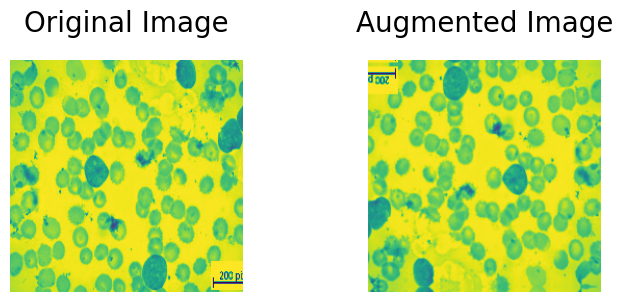

In [ ]:
image = tf.image.rgb_to_grayscale(sample_image)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# View Original Image
ax1.set_title('Original Image', fontsize=20, pad=20)
ax1.imshow(image, cmap='viridis');
ax1.axis('off')

# View Augmented Image
ax2.set_title('Augmented Image', fontsize=20, pad=20)
ax2.imshow(augmentation_layer(image), cmap='viridis');
ax2.axis('off')

## Input Pipeline

In [ ]:
def encode_labels(labels, encode_depth=num_classes):
    return tf.one_hot(labels, depth=encode_depth).numpy()

def create_pipeline(X, y,  load_function, augment=False, batch_size=32, shuffle=False, cache=None, prefetch=False):
    '''
    Generates an input pipeline using the tf.data API given a Pandas DataFrame and image loading function.

    @params
        - X: X contain images path
        - y: y contain the label of corosponding X
        - load_function: (function) -> function used to load images given their paths
        - augment: (bool) -> condition for applying augmentation
        - batch_size: (int) -> size for batched (default=32)
        - shuffle: (bool) -> condition for data shuffling, data is shuffled when True (default=False)
        - cache: (str) -> cache path for caching data, data is not cached when None (default=None)
        - prefetch: (bool) -> condition for prefeching data, data is prefetched when True (default=False)

    @returns
        - dataset: (tf.data.Dataset) -> dataset input pipeline used to train a TensorFlow model
    '''
    # Get image paths and labels from DataFrame
    image_paths = X
    image_labels = encode_labels(y)
    AUTOTUNE = tf.data.AUTOTUNE

    # Create dataset with raw data from DataFrame
    ds = tf.data.Dataset.from_tensor_slices((image_paths, image_labels))

    # Map augmentation layer and load function to dataset inputs if augment is True
    # Else map only the load function
    if augment:
        ds = ds.map(lambda x, y: (augmentation_layer(load_function(x)), y), num_parallel_calls=AUTOTUNE)
    else:
        ds = ds.map(lambda x, y: (load_function(x), y), num_parallel_calls=AUTOTUNE)

    # Apply shuffling based on condition
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)

    # Apply batching
    ds = ds.batch(batch_size)

    # Apply caching based on condition
    # Note: Use cache in memory (cache='') if the data is small enough to fit in memory!!!
    if cache != None:
        ds = ds.cache(cache)

    # Apply prefetching based on condition
    # Note: This will result in memory trade-offs
    if prefetch:
        ds = ds.prefetch(buffer_size=AUTOTUNE)

    # Return the dataset
    return ds

In [ ]:
# Generate Train Input Pipeline
train_ds = create_pipeline(train_x, train_y, _load, augment=True,
                           batch_size=batch_size,
                           shuffle=False, prefetch=True)

# Generate Validation Input Pipeline
val_ds = create_pipeline(valid_x, valid_y, _load,
                         batch_size=batch_size,
                         shuffle=False, prefetch=False)

# Generate Test Input Pipeline
test_ds = create_pipeline(test_x, test_y, _load,
                          batch_size=batch_size,
                          shuffle=False, prefetch=False)

In [ ]:
# View string representation of datasets
print('========================================')
print('Train Input Data Pipeline:\n\n', train_ds)
print('========================================')
print('Validation Input Data Pipeline:\n\n', val_ds)
print('========================================')


Train Input Data Pipeline:

 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>
Validation Input Data Pipeline:

 <_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>


## Helper Function

In [ ]:
def window_partition(x, window_size):
    _, height, width, channels = x.shape
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        x, shape=(-1, patch_num_y, window_size, patch_num_x, window_size, channels)
    )
    x = tf.transpose(x, (0, 1, 3, 2, 4, 5))
    windows = tf.reshape(x, shape=(-1, window_size, window_size, channels))
    return windows


def window_reverse(windows, window_size, height, width, channels):
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        windows,
        shape=(-1, patch_num_y, patch_num_x, window_size, window_size, channels),
    )
    x = tf.transpose(x, perm=(0, 1, 3, 2, 4, 5))
    x = tf.reshape(x, shape=(-1, height, width, channels))
    return x


class DropPath(layers.Layer):
    def __init__(self, drop_prob=None, **kwargs):
        super().__init__(**kwargs)
        self.drop_prob = drop_prob

    def call(self, x):
        input_shape = tf.shape(x)
        batch_size = input_shape[0]
        rank = x.shape.rank
        shape = (batch_size,) + (1,) * (rank - 1)
        random_tensor = (1 - self.drop_prob) + tf.random.uniform(shape, dtype=x.dtype)
        path_mask = tf.floor(random_tensor)
        output = tf.math.divide(x, 1 - self.drop_prob) * path_mask
        return output

## Window based multi-head self-attention

In [ ]:
class WindowAttention(layers.Layer):
    def __init__(
        self, dim, window_size, num_heads, qkv_bias=True, dropout_rate=0.0, **kwargs
    ):
        super().__init__(**kwargs)
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5
        self.qkv = layers.Dense(dim * 3, use_bias=qkv_bias)
        self.dropout = layers.Dropout(dropout_rate)
        self.proj = layers.Dense(dim)

    def build(self, input_shape):
        num_window_elements = (2 * self.window_size[0] - 1) * (
            2 * self.window_size[1] - 1
        )
        self.relative_position_bias_table = self.add_weight(
            shape=(num_window_elements, self.num_heads),
            initializer=tf.initializers.Zeros(),
            trainable=True,
        )
        coords_h = np.arange(self.window_size[0])
        coords_w = np.arange(self.window_size[1])
        coords_matrix = np.meshgrid(coords_h, coords_w, indexing="ij")
        coords = np.stack(coords_matrix)
        coords_flatten = coords.reshape(2, -1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose([1, 2, 0])
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)

        self.relative_position_index = tf.Variable(
            initial_value=tf.convert_to_tensor(relative_position_index), trainable=False
        )

    def call(self, x, mask=None):
        _, size, channels = x.shape
        head_dim = channels // self.num_heads
        x_qkv = self.qkv(x)
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, 3, self.num_heads, head_dim))
        x_qkv = tf.transpose(x_qkv, perm=(2, 0, 3, 1, 4))
        q, k, v = x_qkv[0], x_qkv[1], x_qkv[2]
        q = q * self.scale
        k = tf.transpose(k, perm=(0, 1, 3, 2))
        attn = q @ k

        num_window_elements = self.window_size[0] * self.window_size[1]
        relative_position_index_flat = tf.reshape(
            self.relative_position_index, shape=(-1,)
        )
        relative_position_bias = tf.gather(
            self.relative_position_bias_table, relative_position_index_flat
        )
        relative_position_bias = tf.reshape(
            relative_position_bias, shape=(num_window_elements, num_window_elements, -1)
        )
        relative_position_bias = tf.transpose(relative_position_bias, perm=(2, 0, 1))
        attn = attn + tf.expand_dims(relative_position_bias, axis=0)

        if mask is not None:
            nW = mask.get_shape()[0]
            mask_float = tf.cast(
                tf.expand_dims(tf.expand_dims(mask, axis=1), axis=0), tf.float32
            )
            attn = (
                tf.reshape(attn, shape=(-1, nW, self.num_heads, size, size))
                + mask_float
            )
            attn = tf.reshape(attn, shape=(-1, self.num_heads, size, size))
            attn = tf.keras.activations.softmax(attn, axis=-1)
        else:
            attn = tf.keras.activations.softmax(attn, axis=-1)
        attn = self.dropout(attn)

        x_qkv = attn @ v
        x_qkv = tf.transpose(x_qkv, perm=(0, 2, 1, 3))
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, channels))
        x_qkv = self.proj(x_qkv)
        x_qkv = self.dropout(x_qkv)
        return x_qkv

## SWIN Model

In [ ]:
class SwinTransformer(layers.Layer):
    def __init__(
        self,
        dim,
        num_patch,
        num_heads,
        window_size=7,
        shift_size=0,
        num_mlp=1024,
        qkv_bias=True,
        dropout_rate=0.0,
        **kwargs,
    ):
        super().__init__(**kwargs)

        self.dim = dim  # number of input dimensions
        self.num_patch = num_patch  # number of embedded patches
        self.num_heads = num_heads  # number of attention heads
        self.window_size = window_size  # size of window
        self.shift_size = shift_size  # size of window shift
        self.num_mlp = num_mlp  # number of MLP nodes

        self.norm1 = layers.LayerNormalization(epsilon=1e-5)
        self.attn = WindowAttention(
            dim,
            window_size=(self.window_size, self.window_size),
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            dropout_rate=dropout_rate,
        )
        self.drop_path = DropPath(dropout_rate)
        self.norm2 = layers.LayerNormalization(epsilon=1e-5)

        self.mlp =tf.keras.Sequential(
            [
                layers.Dense(num_mlp),
                layers.Activation(tf.keras.activations.gelu),
                layers.Dropout(dropout_rate),
                layers.Dense(dim),
                layers.Dropout(dropout_rate),
            ]
        )

        if min(self.num_patch) < self.window_size:
            self.shift_size = 0
            self.window_size = min(self.num_patch)

    def build(self, input_shape):
        if self.shift_size == 0:
            self.attn_mask = None
        else:
            height, width = self.num_patch
            h_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            w_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            mask_array = np.zeros((1, height, width, 1))
            count = 0
            for h in h_slices:
                for w in w_slices:
                    mask_array[:, h, w, :] = count
                    count += 1
            mask_array = tf.convert_to_tensor(mask_array)

            # mask array to windows
            mask_windows = window_partition(mask_array, self.window_size)
            mask_windows = tf.reshape(
                mask_windows, shape=[-1, self.window_size * self.window_size]
            )
            attn_mask = tf.expand_dims(mask_windows, axis=1) - tf.expand_dims(
                mask_windows, axis=2
            )
            attn_mask = tf.where(attn_mask != 0, -100.0, attn_mask)
            attn_mask = tf.where(attn_mask == 0, 0.0, attn_mask)
            self.attn_mask = tf.Variable(initial_value=attn_mask, trainable=False)

    def call(self, x):
        height, width = self.num_patch
        _, num_patches_before, channels = x.shape
        x_skip = x
        x = self.norm1(x)
        x = tf.reshape(x, shape=(-1, height, width, channels))
        if self.shift_size > 0:
            shifted_x = tf.roll(
                x, shift=[-self.shift_size, -self.shift_size], axis=[1, 2]
            )
        else:
            shifted_x = x

        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = tf.reshape(
            x_windows, shape=(-1, self.window_size * self.window_size, channels)
        )
        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        attn_windows = tf.reshape(
            attn_windows, shape=(-1, self.window_size, self.window_size, channels)
        )
        shifted_x = window_reverse(
            attn_windows, self.window_size, height, width, channels
        )
        if self.shift_size > 0:
            x = tf.roll(
                shifted_x, shift=[self.shift_size, self.shift_size], axis=[1, 2]
            )
        else:
            x = shifted_x

        x = tf.reshape(x, shape=(-1, height * width, channels))
        x = self.drop_path(x)
        x = x_skip + x
        x_skip = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = self.drop_path(x)
        x = x_skip + x
        return x

## Extract and embed patches

In [ ]:
class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size_x = patch_size[0]
        self.patch_size_y = patch_size[0]

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=(1, self.patch_size_x, self.patch_size_y, 1),
            strides=(1, self.patch_size_x, self.patch_size_y, 1),
            rates=(1, 1, 1, 1),
            padding="VALID",
        )
        patch_dim = patches.shape[-1]
        patch_num = patches.shape[1]
        return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = tf.range(start=0, limit=self.num_patch, delta=1)
        return self.proj(patch) + self.pos_embed(pos)


class PatchMerging(tf.keras.layers.Layer):
    def __init__(self, num_patch, embed_dim):
        super().__init__()
        self.num_patch = num_patch
        self.embed_dim = embed_dim
        self.linear_trans = layers.Dense(2 * embed_dim, use_bias=False)

    def call(self, x):
        height, width = self.num_patch
        _, _, C = x.get_shape().as_list()
        x = tf.reshape(x, shape=(-1, height, width, C))
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = tf.concat((x0, x1, x2, x3), axis=-1)
        x = tf.reshape(x, shape=(-1, (height // 2) * (width // 2), 4 * C))
        return self.linear_trans(x)

## Build the model

In [ ]:
def create_swin_model():

    input = layers.Input(input_shape)
    augmented = augmentation_layer(input)
    x = PatchExtract(patch_size)(augmented)
    x = PatchEmbedding(num_patch_x * num_patch_y, embed_dim)(x)
    x = SwinTransformer(
        dim=embed_dim,
        num_patch=(num_patch_x, num_patch_y),
        num_heads=num_heads,
        window_size=window_size,
        shift_size=0,
        num_mlp=num_mlp,
        qkv_bias=qkv_bias,
        dropout_rate=dropout_rate,
    )(x)
    x = SwinTransformer(
        dim=embed_dim,
        num_patch=(num_patch_x, num_patch_y),
        num_heads=num_heads,
        window_size=window_size,
        shift_size=shift_size,
        num_mlp=num_mlp,
        qkv_bias=qkv_bias,
        dropout_rate=dropout_rate,
    )(x)
    x = PatchMerging((num_patch_x, num_patch_y), embed_dim=embed_dim)(x)
    x = layers.GlobalAveragePooling1D()(x)

    # Apply sequence pooling
    seq_representation = layers.LayerNormalization(epsilon=1e-5)(X)


    attention_weights = tf.nn.softmax(layers.Dense(1)(seq_representation), axis=1)

    weighted_seq_representation = tf.matmul(
        attention_weights,
        seq_representation,
        transpose_a=True
    )
    weighted_seq_representation = tf.squeeze(weighted_seq_representation, -2)

    output = layers.Dense(num_classes, activation="softmax")(weighted_seq_representation)


      # Generate Model
    model = tf.keras.Model(inputs=[input], outputs=[output], name='swin_transformer_model_all')
    return model

In [ ]:
model = create_swin_model()

In [ ]:
model.summary()

Model: "swin_transformer_model_all"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 augmentation_layer (Sequen  (224, 224, 3)             0         
 tial)                                                           
                                                                 
 patch_extract (PatchExtrac  (None, 784, 192)          0         
 t)                                                              
                                                                 
 patch_embedding (PatchEmbe  (None, 784, 64)           62528     
 dding)                                                          
                                                                 
 swin_transformer (SwinTran  (None, 784, 64)           50632     
 sformer)                               

### CallBack Phases

In [ ]:
paths = '/content/drive/MyDrive/Research Paper/Health Science/Paper/Acute Lymphoblastic Leukemia/Model'
model_path = os.path.join(paths+"/files/", "swin_model.tf")
csv_path = os.path.join(paths+"/files/", "swin_log.csv")
#--------------------------------------------
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping
#--------------------------------------------------------
# Define Early Stopping Callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True)

# (Optional) Define Reduce Learning Rate Callback
# reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor='val_loss',
#     patience=6,
#     factor=0.1,
#     verbose=1)

# Define Callbacks and Metrics lists
CALLBACKS = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-10, verbose=1),
        CSVLogger(csv_path),
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
    ]

METRICS = ['accuracy']

### Compiling Phase

In [ ]:
tf.random.set_seed(42)

# Compile the model
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False,label_smoothing=0.0,axis=-1,reduction="auto",name="categorical_crossentropy",
),
    optimizer=tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay),
    metrics=METRICS
)

# Train the model
print(f'Training {model.name}.')
print(f'Train on {len(train_x)}, {len(train_y)} samples, validate on {len(valid_x)}, {len(valid_y)} samples.')
print('----------------------------------')



Training swin_transformer_model_all.
Train on 2604, 2604 samples, validate on 326, 326 samples.
----------------------------------


In [ ]:
tf.keras.backend.clear_session()

## Training Phase

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=batch_size,
    epochs=num_epochs,
    callbacks=CALLBACKS,
)

Epoch 1/500
21/21 [==============================] - 65s 1s/step - loss: 2.1455 - accuracy: 0.3260 - val_loss: 1.3360 - val_accuracy: 0.3282 - lr: 0.0010
Epoch 2/500
21/21 [==============================] - 28s 1s/step - loss: 1.3111 - accuracy: 0.3740 - val_loss: 1.1847 - val_accuracy: 0.4816 - lr: 0.0010
Epoch 3/500
21/21 [==============================] - 29s 1s/step - loss: 1.0507 - accuracy: 0.5664 - val_loss: 1.0472 - val_accuracy: 0.4724 - lr: 0.0010
Epoch 4/500
21/21 [==============================] - 27s 1s/step - loss: 1.0196 - accuracy: 0.5710 - val_loss: 0.9485 - val_accuracy: 0.5583 - lr: 0.0010
Epoch 5/500
21/21 [==============================] - 29s 1s/step - loss: 0.9591 - accuracy: 0.6202 - val_loss: 0.8370 - val_accuracy: 0.7025 - lr: 0.0010
Epoch 6/500
21/21 [==============================] - 28s 1s/step - loss: 0.8262 - accuracy: 0.6897 - val_loss: 0.6901 - val_accuracy: 0.8067 - lr: 0.0010
Epoch 7/500
21/21 [==============================] - 28s 1s/step - loss: 0.6

# Valid Sets

## Prediction Phase

In [ ]:
# Generate model probabilities and associated predictions
test_probabilities = model.predict(val_ds, verbose=1)
test_predictions = tf.argmax(test_probabilities, axis=1)

3/3 [==============================] - 3s 734ms/step


### Plot Evaluation Graphs

In [ ]:
def plot_training_curves(history, ):

    loss = np.array(history.history['loss'])
    val_loss = np.array(history.history['val_loss'])

    accuracy = np.array(history.history['accuracy'])
    val_accuracy = np.array(history.history['val_accuracy'])

    epochs = range(len(history.history['loss']))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss', marker='o')
    ax1.plot(epochs, val_loss, label='val_loss', marker='o')

    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)

    ax1.set_title('Loss (Lower Means Better)', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.legend()

    # Plot accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='o')
    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='o')

    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)

    ax2.set_title('Accuracy (Higher Means Better)', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.legend();

    sns.despine();

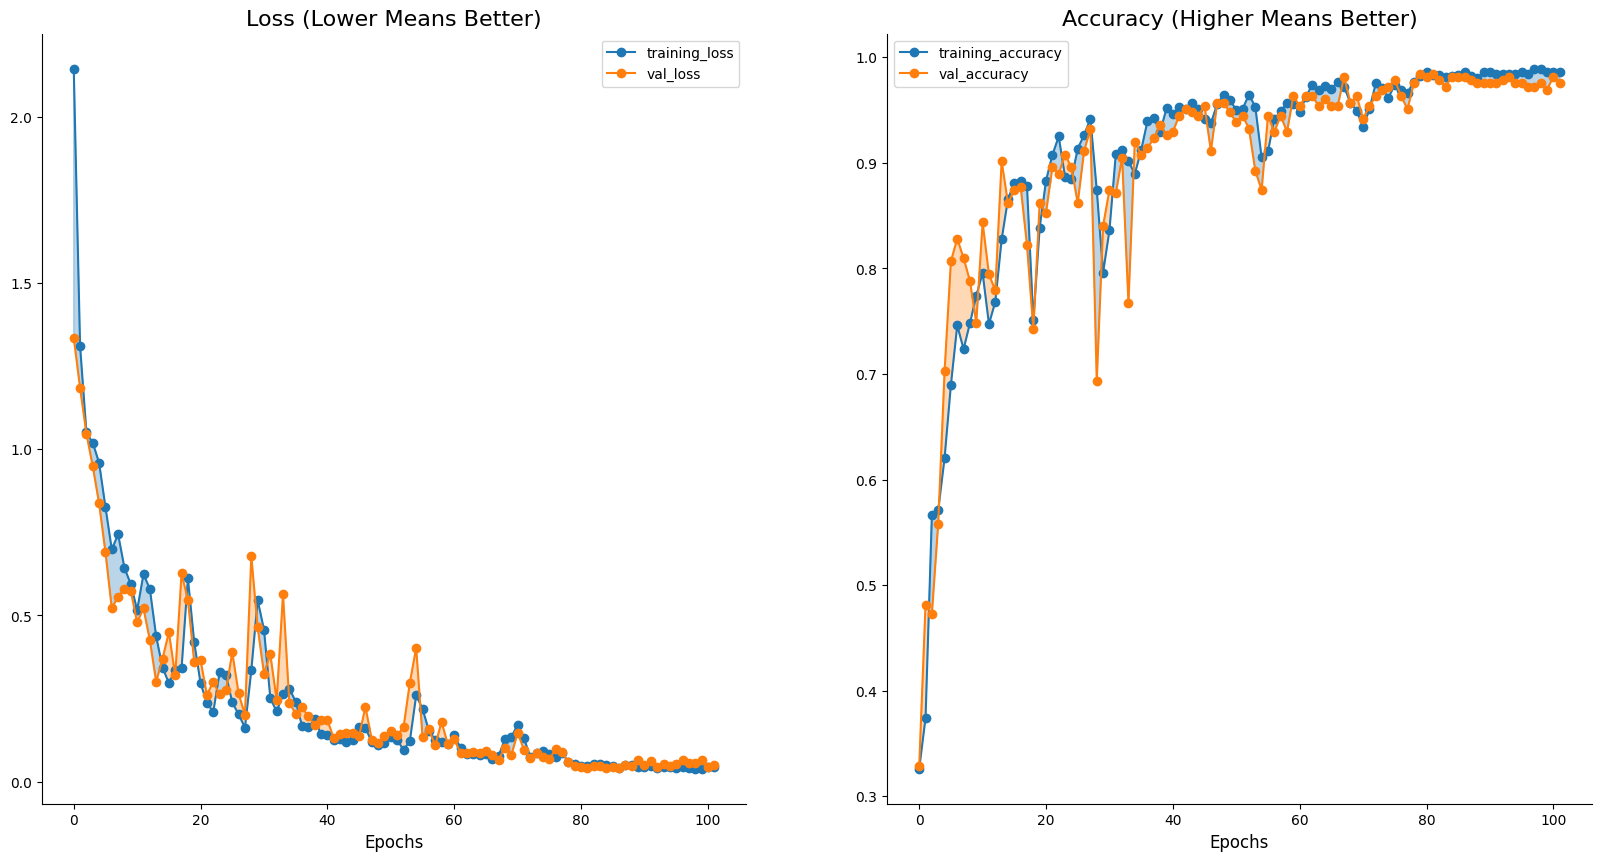

In [ ]:
# plot cct model training history
plot_training_curves(history)

### Plot Confusion Matrix

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10, 10), text_size=12):
    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Set plot size
    plt.figure(figsize=figsize)

    # Create confusion matrix heatmap
    disp = sns.heatmap(
        cm, annot=True, cmap='Greens',
        annot_kws={"size": text_size}, fmt='g',
        linewidths=0.1, linecolor='black', clip_on=False,
        xticklabels=classes, yticklabels=classes)

    # Set title and axis labels
    disp.set_title('Confusion Matrix', fontsize=24)
    disp.set_xlabel('Predicted Label', fontsize=20)
    disp.set_ylabel('True Label', fontsize=20)
    plt.yticks(rotation=0)

    # Plot confusion matrix
    plt.show()

    return

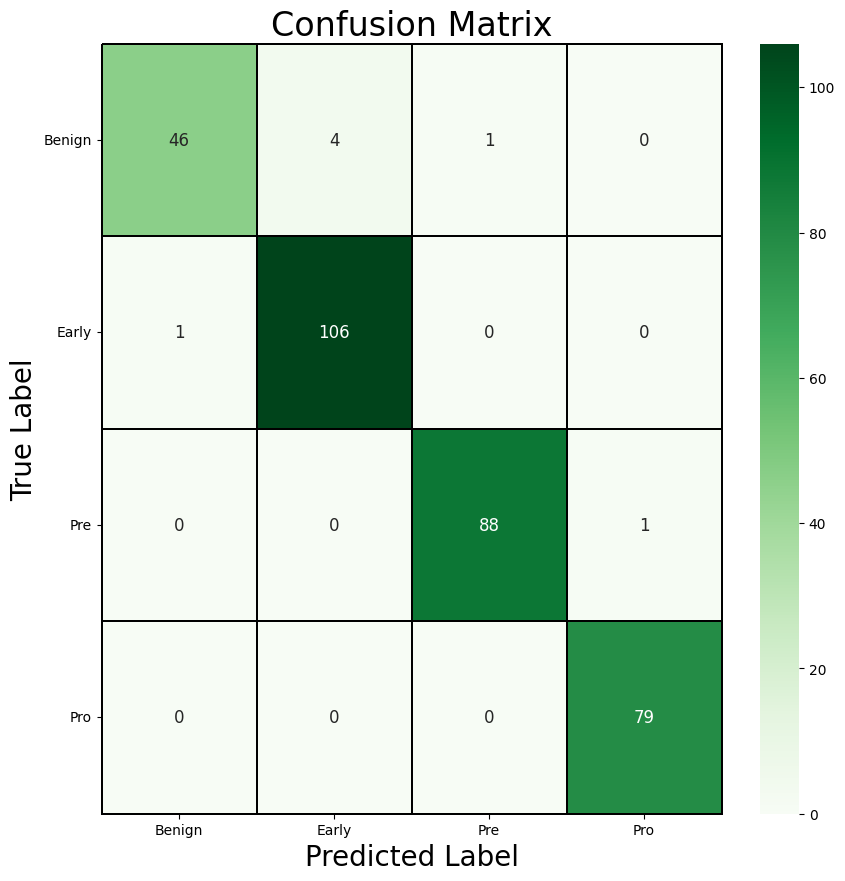

In [ ]:
class_names = ['Benign', 'Early', 'Pre', 'Pro']

plot_confusion_matrix(
    valid_y,
    test_predictions,
    figsize=(10, 10),
    classes=class_names)

## Plot ROC

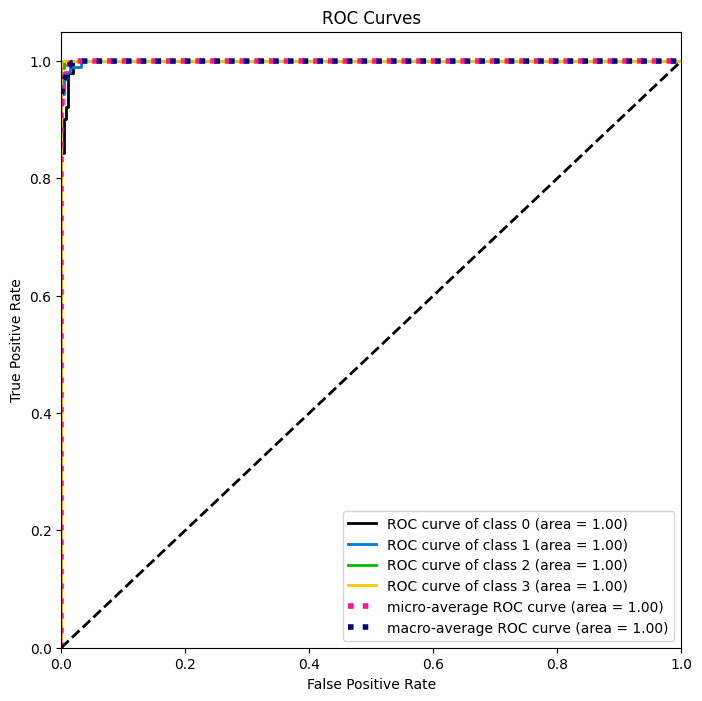

In [ ]:
plot_roc(valid_y,
         test_probabilities,
         figsize=(8, 8), title_fontsize='large');

In [ ]:
print(classification_report(valid_y,
                            test_predictions,
                            target_names=class_names))

              precision    recall  f1-score   support

      Benign       0.98      0.90      0.94        51
       Early       0.96      0.99      0.98       107
         Pre       0.99      0.99      0.99        89
         Pro       0.99      1.00      0.99        79

    accuracy                           0.98       326
   macro avg       0.98      0.97      0.97       326
weighted avg       0.98      0.98      0.98       326



## Performance Evaluation

In [ ]:
def generate_preformance_scores(y_true, y_pred, y_probabilities):

    model_accuracy = accuracy_score(y_true, y_pred)
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true,
                                                                                 y_pred,
                                                                                 average="weighted")
    model_matthews_corrcoef = matthews_corrcoef(y_true, y_pred)

    print('=============================================')
    print(f'\nPerformance Metrics:\n')
    print('=============================================')
    print(f'accuracy_score:\t\t{model_accuracy:.4f}\n')
    print('_____________________________________________')
    print(f'precision_score:\t{model_precision:.4f}\n')
    print('_____________________________________________')
    print(f'recall_score:\t\t{model_recall:.4f}\n')
    print('_____________________________________________')
    print(f'f1_score:\t\t{model_f1:.4f}\n')
    print('_____________________________________________')
    print(f'matthews_corrcoef:\t{model_matthews_corrcoef:.4f}\n')
    print('=============================================')

    preformance_scores = {
        'accuracy_score': model_accuracy,
        'precision_score': model_precision,
        'recall_score': model_recall,
        'f1_score': model_f1,
        'matthews_corrcoef': model_matthews_corrcoef
    }
    return preformance_scores

In [ ]:
# Record CCT model performance scores
performance = generate_preformance_scores(valid_y,
                                              test_predictions,
                                              test_probabilities)


Performance Metrics:

accuracy_score:		0.9785

_____________________________________________
precision_score:	0.9786

_____________________________________________
recall_score:		0.9785

_____________________________________________
f1_score:		0.9783

_____________________________________________
matthews_corrcoef:	0.9709



# Test Sets

In [ ]:
# Generate model probabilities and associated predictions
test_probabilities = model.predict(test_ds, verbose=1)
test_predictions = tf.argmax(test_probabilities, axis=1)

3/3 [==============================] - 124s 37s/step


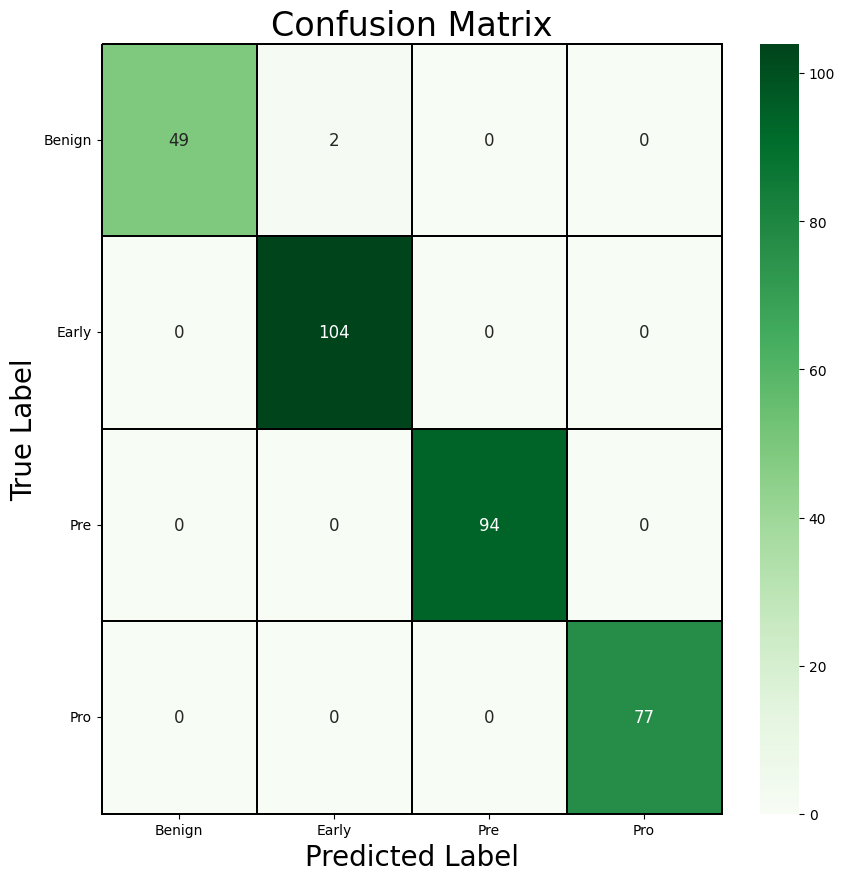

In [ ]:
class_names = ['Benign', 'Early', 'Pre', 'Pro']

plot_confusion_matrix(
    test_y,
    test_predictions,
    figsize=(10, 10),
    classes=class_names)

In [ ]:
print(classification_report(test_y,
                            test_predictions,
                            target_names=class_names))

              precision    recall  f1-score   support

      Benign       1.00      0.96      0.98        51
       Early       0.98      1.00      0.99       104
         Pre       1.00      1.00      1.00        94
         Pro       1.00      1.00      1.00        77

    accuracy                           0.99       326
   macro avg       1.00      0.99      0.99       326
weighted avg       0.99      0.99      0.99       326



In [ ]:
# Record CCT model performance scores
cct_performance = generate_preformance_scores(test_y,
                                              test_predictions,
                                              test_probabilities)


Performance Metrics:

accuracy_score:		0.9939

_____________________________________________
precision_score:	0.9940

_____________________________________________
recall_score:		0.9939

_____________________________________________
f1_score:		0.9938

_____________________________________________
matthews_corrcoef:	0.9917

